In [1]:
import os
import dotenv
import subprocess
import shlex

import sys
sys.path.append('../utils')
from utils import load_json, export_json

In [2]:
#Definir local de arquivo .jar e dados utilizados pelo SentiStrength
dotenv.load_dotenv()
SENTISTRENGTH_JAR_PATH = os.getenv('SENTISTRENGTH_JAR_PATH')
SENTISTRENGTH_DATA_PATH = os.getenv('SENTISTRENGTH_DATA_PATH')

In [3]:
if not os.path.isfile(SENTISTRENGTH_JAR_PATH):
    print("SentiStrength not found at: ", SENTISTRENGTH_JAR_PATH)
if not os.path.isdir(SENTISTRENGTH_DATA_PATH):
    print("SentiStrength data folder not found at: ", SENTISTRENGTH_DATA_PATH)

TypeError: stat: path should be string, bytes, os.PathLike or integer, not NoneType

In [ ]:

def RateSentiment(sentiString):
    #open a subprocess using shlex to get the command line string into the correct args list format
    #Modify the location of SentiStrength.jar and D:/SentiStrength_Data/ if necessary
    p = subprocess.Popen(shlex.split("java -jar '" + SENTISTRENGTH_JAR_PATH + "' stdin sentidata '" + SENTISTRENGTH_DATA_PATH + "'"),stdin=subprocess.PIPE,stdout=subprocess.PIPE,stderr=subprocess.PIPE)
    #communicate via stdin the string to be rated. Note that all spaces are replaced with +
    #Can't send string in Python 3, must send bytes
    b = bytes(sentiString.replace(" ","+"), 'utf-8')
    stdout_byte, stderr_text = p.communicate(b)
    #convert from byte
    stdout_text = stdout_byte.decode("utf-8") 
    #replace the tab with a space between the positive and negative ratings. e.g. 1    -5 -> 1 -5
    stdout_text = stdout_text.rstrip().replace("\t"," ")
    return stdout_text
#An example to illustrate calling the process.
print(RateSentiment("The sweetness is extremely high, and the base is still sauce."))

#The above is OK for one text but inefficient to repeatedly call for many texts. Try instead: 
#  either modify the above to submit a file
#  or modify the above to send multiple lines through multiple calls of p.communicate(b)

3 -1


In [ ]:
import os

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r"googlekey.json"


def translate_text(target: str, text: str) -> dict:
    """Translates text into the target language.

    Target must be an ISO 639-1 language code.
    See https://g.co/cloud/translate/v2/translate-reference#supported_languages
    """
    from google.cloud import translate_v2 as translate

    translate_client = translate.Client()

    if isinstance(text, bytes):
        text = text.decode("utf-8")

    # Text can also be a sequence of strings, in which case this method
    # will return a sequence of results for each text.
    result = translate_client.translate(text, target_language=target)

    #print("Text: {}".format(result["input"]))
    #print("Translation: {}".format(result["translatedText"]))
    #print("Detected source language: {}".format(result["detectedSourceLanguage"]))

    return result


print(translate_text("en", "Olá, tudo bem?"))

{'translatedText': 'Hello everything is fine?', 'detectedSourceLanguage': 'pt', 'input': 'Olá, tudo bem?'}


### Traduzindo todos os comentários para o idioma inglês e salvando em um novo arquivo

In [ ]:
path = '../data/beer_data/'
file_name = "comments_by_beer.json"

data = load_json(path + file_name)

print(data)

{'/b/spartacus-brewing-iii-three/4283069': [{'user': '/user/BurningHorizons', 'comment': 'LCI PITFEST '}, {'user': '/user/EnzoSago', 'comment': 'Tjs aussi cool. Les adjuncts sont plus posés. '}, {'user': '/user/MarekSlawecki', 'comment': 'Masterpiece '}, {'user': '/user/NoTimeLeft', 'comment': '太他妈甜了....兑着喝还算可以 '}, {'user': '/user/qwegkm', 'comment': '甜度爆高，底子还是酱，相比four的甜度增味种类多，three的甜度更高但单一，略微显出底子的酱味，漂亮。4.7 '}, {'user': '/user/RodolphoMaximo', 'comment': 'É ainda deu bom brejas do armário q em mudança achamos '}, {'user': '/user/LeeHomeRain', 'comment': '巴西第一酒厂斯巴达克斯2021年的三周年世涛，目前喝过最好喝的甜品世涛！第一口惊艳！在两款波旁威士忌桶陈酿，倒入杯中酒体中等不稠，第一口就像是吃冰激凌一样，刚入口的甜抓住你，酒体超级顺滑，不自主的滑下喉咙，在喉咙处开始回口给你烤椰子、肉桂、咖啡、黑巧等等丰富味道体验，特别的惊喜，尤其是你并没太在意的时候，超级爽！有酒友有跟红叔同样感受，桶与酒的完美融合！红叔给满分！2023.5.14开罐饮用 '}, {'user': '/user/kjsheed', 'comment': '4.6'}, {'user': '/user/bierbarbaarMichel', 'comment': 'Wat een blubberdikke mes en vork stout. Bomvol espresso karamel cappuccino geroosterde hazelnoten kokosnoot esdoornsiroop dadels pure chocolade 

In [ ]:
for item in data:
    beer_comments_current_beer = data[item]
    for comment in beer_comments_current_beer:
        comment_text = comment['comment']
        translate_result = translate_text("en", comment_text)
        comment['translatedComment'] = translate_result['translatedText']
        print('translatedComment : ', comment['translatedComment'])

In [ ]:
#path = '../data/'
#comments_by_beer_translated_file_name = 'comments_by_beer_translated.json'
#export_json(data, path + comments_by_beer_translated_file_name)

### Computando análise de sentimento para comentários traduzidos para o inglês

In [ ]:
path = '../data/beer_data/'
file_name = "comments_by_beer_translated.json"

data = load_json(path + file_name)

for item in data:
    beer_comments_current_beer = data[item]
    for comment in beer_comments_current_beer:
        comment_text_translated = comment['translatedComment']
        senti_strength_result = RateSentiment(comment_text_translated)
        comment['SentiStrength_Positive'] = senti_strength_result.split(' ')[0]
        comment['SentiStrength_Negative'] = senti_strength_result.split(' ')[1]

In [ ]:
#path = '../data/'
#comments_by_beer_sentiment_file_name = 'comments_by_beer_sentiment.json'
#export_json(data, path + comments_by_beer_sentiment_file_name)

Plotando média das notas por cerveja:

/b/spartacus-brewing-iii-three/4283069 0.4479166666666667
/b/spartacus-brewing-v-five/5285289 0.4557291666666667
/b/spartacus-brewing-iv-four/4756418 0.46830985915492956
/b/hocus-pocus-overdrive/1682105 0.47337278106508873
/b/spartacus-brewing-arete-tomo-2/4542383 0.46565934065934067
/b/salvador-brewing-co-cookie-de-chocolate/2908960 0.45
/b/spartacus-brewing-etera-tomo-5/4769967 0.43702290076335876
/b/hocus-pocus-elephants-graveyard/2769185 0.4406196213425129
/b/spartacus-brewing-arete-tomo-1/4098457 0.4451219512195122
/b/cervejaria-dogma-rizoma/1536694 0.445480631276901
/b/hocus-pocus-supersymmetry/1930404 0.4344262295081967
/b/koala-san-brew-cosmic-blur/3452440 0.4162531017369727
/b/trilha-cervejaria-pao-de-mel/3252352 0.4188422247446084
/b/hocus-pocus-rabbit-hole/2321900 0.4291044776119403
/b/spartacus-brewing-fwiw/3905760 0.42806841046277666
/b/spartacus-brewing-barrel-aged-icon-double-chocolate-peanut-butter/5076259 0.42997198879551823
/b/cervejaria-dogma-mosaic-lover/1698497 0.4

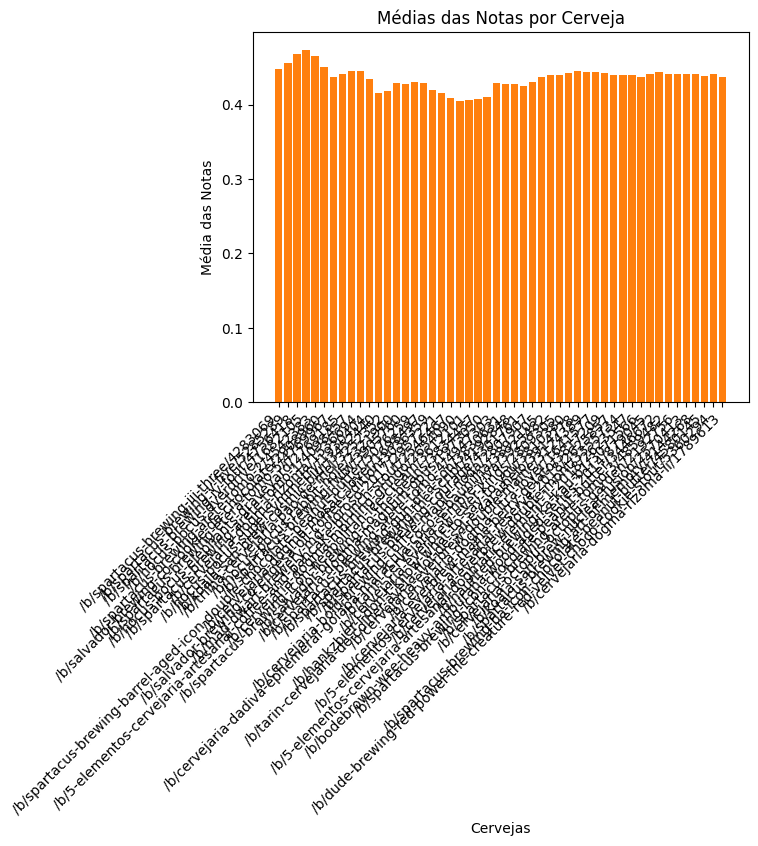

In [14]:
import json
import matplotlib.pyplot as plt

with open('../data/beer_data/comments_by_beer_sentiment.json', 'r') as file:
    dados_json = json.load(file)

medias = {}
notas =[]

for chave, lista in dados_json.items():
    for item in lista:
        notas.append(int(item.get("SentiStrength_Positive", "N/A")))
        notas.append(int(item.get("SentiStrength_Negative", "N/A")))
    medias.update({chave:(sum(notas) / len(notas))})
    
for k, v in medias.items():
    print(k, v)

cervejas = list(medias.keys())
medias = list(medias.values())

plt.bar(cervejas, medias)
plt.bar(cervejas, medias)
plt.xlabel('Cervejas')
plt.ylabel('Média das notas')
plt.title('Médias das notas por cerveja')
plt.xticks(rotation=45, ha='right')
plt.show()